<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_2/blob/main/Extend_dataset_YOLOv5_chizai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*GO extend datasetYOLOv5_for_chizai*

※YOLOv5-GradCAMを試みたが、結局うまくいっていない...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys
import torch

import glob
import random
from PIL import Image
%matplotlib inline

# #サポートパッチのインポート
# from google.colab.patches import cv2_imshow
# import cv2

plt.ion()   # interactive mode
!nvidia-smi
print(torch.cuda.is_available())


random_seed = 3 #shuffleのシード

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2



/bin/bash: line 1: nvidia-smi: command not found
False


#Google colabをマウント

In [2]:
'''
・YOLOv5のモデルを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**YOLOv5 Inference of sample images**

yolov5n_130epch.pt (developed using Osaka Univ dataset)

In [ ]:
# YOLOv5
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolov5n_130epch.pt"

# 横幅を640pxにリサイズしたデータセット
dataset_olympia_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav"
dataset_olympia_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont"
dataset_handai_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/grav"
dataset_handai_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/cont"

In [ ]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish

import torch
import utils
%pip install -qr requirements.txt
display = utils.notebook_init()


In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob


image_path = glob.glob(f"{dataset_olympia_cont}/*")
start_index = 1
end_index = 5

class_names = {0: "cont", 1: "grav"}

for i in range(start_index, end_index + 1):
    img = image_path[i]

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" % (class_name, prob * 100))

    img_cv2 = cv2.imread(img)
    img_cv2 = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height)) / 2
    padding_y = (img_width - min(img_width, img_height)) / 2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    cv2_imshow(img_cv2)

#**YOLOv5-GradCAM (新バージョン)**

In [5]:
# YOLOv5
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolov5n_130epch.pt"

# 横幅を640pxにリサイズしたデータセット
dataset_olympia_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav"
dataset_olympia_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont"
dataset_handai_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/grav"
dataset_handai_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/cont"

In [6]:
###モデルの読み込み
import torch
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish
hubconf_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish"
model_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
#model = torch.hub.load(hubconf_path, 'custom', model_path, source='local')
model = torch.hub.load(hubconf_path, 'custom', model_path, autoshape=True, source='local')

#model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False)  # load pretrained
#print(model(torch.randn(1,3,640,640)))

/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 208.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.2s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


EigenCAM
安定しない

https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html

In [ ]:
%cd /content
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

!pip install ttach --q
%cd /content/pytorch-grad-cam

In [ ]:
#modules
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

image_url = "/content/drive/MyDrive/AI_laboratory_course/bus.jpeg"
#image_url = "/content/drive/MyDrive/AI_laboratory_course/goldenretriever-3724972_640.jpg"
#image_url = glob.glob(f"{dataset_olympia_grav}/*")[1]
img = cv2.imread(image_url) #CV2で開く
#img = cv2.resize(img, (640, 640))
img = letterbox(img, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
cv2_imshow(detections)
#Image.fromarray(detections)

In [ ]:
cam = EigenCAM(model, target_layers)
grayscale_cam = cam(img_tensor)[0, :, :] #[1,3,640,640] --> [3,640,640]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
cv2_imshow(cam_image)

In [89]:
from pytorch_grad_cam import GradCAM
with torch.enable_grad():
    cam = GradCAM(model, target_layers)
    cam(img_tensor)

RuntimeError: ignored

In [ ]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
cv2_imshow(renormalized_cam_image)

image 1/1: 1728x2592 1 grav
Speed: 17.6ms pre-process, 76.4ms inference, 26.0ms NMS per image at shape (1, 3, 448, 640)
[tensor([[0.00000e+00, 4.16851e+02, 2.52050e+03, 1.18727e+03, 7.09801e-01, 1.00000e+00]])]
Pred: grav


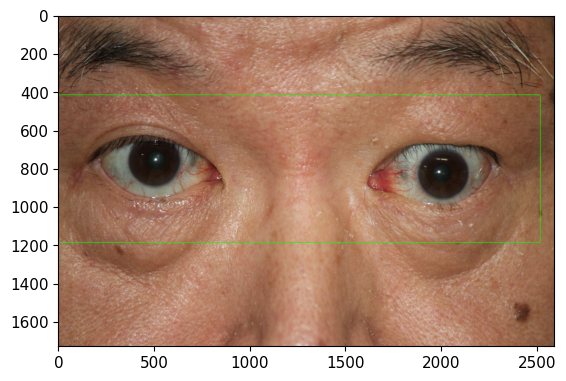

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread(glob.glob(f"{dataset_olympia_grav}/*")[0])
result = model(img)
print(result)
print(result.pred)
#print(result.pandas().xyxy)

print(f"Pred: {result.pandas().xyxy[0].name.item()}")
result_df = result.pandas().xyxy[0]

# 画像上に境界ボックスを描画
for index, row in result_df.iterrows():
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# 画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish

import torch
import utils
%pip install -qr requirements.txt
display = utils.notebook_init()

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.1.0+cu121 CPU


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.3/225.8 GB disk)


In [9]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def inference(img, model):
    device = 'cpu'
    device = select_device(device)
    #model = DetectMultiBackend(weight, device=device, dnn=False)

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応

    pred = model(img_tensor)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [10]:
img_path = glob.glob(f"{dataset_olympia_grav}/*")[1]
model = model

inference(img_path, model)

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.1.0+cu121 CPU



pred: [tensor([[ -3.80017, 211.79117, 626.05798, 405.38937,   0.90550,   1.00000]])]


[tensor([[ -3.80017, 211.79117, 626.05798, 405.38937,   0.90550,   1.00000]])]

In [21]:
##################
## YOLO5-GradCAM ##
##################

import time
import torch
import torch.nn.functional as F


def find_yolo_layer(model, layer_name):
    """Find yolov5 layer to calculate GradCAM and GradCAM++

    Args:
        model: yolov5 model.
        layer_name (str): the name of layer with its hierarchical information.

    Return:
        target_layer: found layer
    """
    hierarchy = layer_name.split('_')
    target_layer = model.model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer


class YOLOV5GradCAM:

    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))
        print('[INFO] saliency_map size :', self.activations['value'].shape[2:])

    def forward(self, input_img, class_idx=True):
        """
        Args:
            input_img: input image with shape of (1, 3, H, W)
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
            preds: The object predictions
        """
        saliency_maps = []
        b, c, h, w = input_img.size()
        tic = time.time()
        preds, logits = self.model(input_img)
        print("[INFO] model-forward took: ", round(time.time() - tic, 4), 'seconds')
        for logit, cls, cls_name in zip(logits[0], preds[1][0], preds[2][0]):
            if class_idx:
                score = logit[cls]
            else:
                score = logit.max()
            self.model.zero_grad()
            tic = time.time()
            score.backward(retain_graph=True)
            print(f"[INFO] {cls_name}, model-backward took: ", round(time.time() - tic, 4), 'seconds')
            gradients = self.gradients['value']
            activations = self.activations['value']
            b, k, u, v = gradients.size()
            alpha = gradients.view(b, k, -1).mean(2)
            weights = alpha.view(b, k, 1, 1)
            saliency_map = (weights * activations).sum(1, keepdim=True)
            saliency_map = F.relu(saliency_map)
            saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
            saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
            saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
            saliency_maps.append(saliency_map)
        return saliency_maps, logits, preds

    def __call__(self, input_img):
        return self.forward(input_img)

In [15]:
###################
## YOLOv5-GradCAM ##
###################

import time
import torch
import torch.nn.functional as F

from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow

def find_yolo_layer(model, layer_name):
    """Find yolov5 layer to calculate GradCAM and GradCAM++

    Args:
        model: yolov5 model.
        layer_name (str): the name of layer with its hierarchical information.

    Return:
        target_layer: found layer
    """
    hierarchy = layer_name.split('_')
    target_layer = model.model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
        #print(target_layer)
    return target_layer

class YOLOV5GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        feature_layer = find_yolo_layer(self.model, self.layer_name)

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]])
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

def preprocess (img_path):
    img_cv2 = cv2.imread(img_path) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応
    return img_tensor

In [16]:
# Set parameters
img_path = glob.glob(f"{dataset_olympia_grav}/*")[1]
target_layer = "model_23_cv3_act" #デフォルトはYOLOv5sだがどのモデルでも同じっぽい
names = ["cont", "grav"]

In [17]:
gradcam = YOLOV5GradCAM(model, layer_name = "model_23_cv3_act")

In [19]:
img_tensor = preprocess(img_path)
output = gradcam.forward(img_tensor)
output_nms = non_max_suppression(output, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)
pred_class = output_nms[0][0][5]

In [ ]:
print(f"output: {output_nms}")
print(f"pred_class: {pred_class}")

In [22]:
gradcam.backward_on_target(output_nms, pred_class)


AttributeError: ignored

ChatGPT implemenatation --> うまくいかず

何をbackwardさせればよいかよくわからず

In [24]:
def find_yolo_layer(model, layer_name):
    """Find yolov5 layer to calculate GradCAM and GradCAM++

    Args:
        model: yolov5 model.
        layer_name (str): the name of layer with its hierarchical information.

    Return:
        target_layer: found layer
    """
    hierarchy = layer_name.split('_')
    target_layer = model.model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient = None
        self.activation = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        # 対象層にフックを登録（ここでfind_yolo_layer関数を使用）
        target_layer = find_yolo_layer(self.model, self.layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_image, class_idx):
        # 予測を行う
        outputs = self.model(input_image)

        # NMSを適用
        output_nms = non_max_suppression(outputs, conf_thres=0.25, iou_thres=0.45, classes=None, max_det=1000)

        print(output_nms)
        # NMSの結果から最初の検出を取得
        if len(output_nms[0]) == 0:
            raise ValueError("No detections found")
        detection = output_nms[0][0]

        # 検出のクラス確率を取得
        pred_class_prob = detection[4]

        # 逆伝播で勾配を取得
        self.model.zero_grad()
        output_nms.backward()

        # 勾配と特徴マップを取得
        gradients = self.gradient
        activations = self.activation
        b, k, u, v = activations.size()

        # 勾配の平均を計算
        alpha = gradients.view(b, k, -1).mean(2)

        # 重みを特徴マップに適用し、ReLUを通してヒートマップを生成
        weights = alpha.view(b, k, 1, 1)
        heatmap = torch.relu(torch.sum(weights * activations, dim=1, keepdim=True))

        return heatmap

    def superimpose(self, original_image, heatmap):
        # ヒートマップをリサイズして元の画像と同じサイズにする
        heatmap = cv2.resize(heatmap[0].cpu().numpy(), (original_image.shape[1], original_image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # 元の画像にヒートマップを重ねる
        superimposed_img = heatmap * 0.4 + original_image
        return superimposed_img

# 画像の前処理
def preprocess_image(img_path, size=640):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # YOLOv5の前処理
    img = letterbox(img, size, stride=32, auto=True)[0]
    img = img.transpose((2, 0, 1))
    img = torch.from_numpy(img).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

# GradCAMの適用
def apply_gradcam(img_path, model, target_layer, class_idx):
    model.eval()
    # 画像の前処理
    img = preprocess_image(img_path)
    img.requires_grad_(True)  # 勾配計算を有効化

    # GradCAMの初期化
    gradcam = GradCAM(model, target_layer)

    # ヒートマップの生成
    heatmap = gradcam.generate_heatmap(img, class_idx)

    # 元の画像を読み込む
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # ヒートマップを元の画像に重ねる
    superimposed_img = gradcam.superimpose(original_img, heatmap)

    # 結果の表示
    plt.imshow(superimposed_img / 255)
    plt.axis('off')
    plt.show()

# 使用例
# Set parameters
img_path = glob.glob(f"{dataset_olympia_cont}/*")[0]
target_layer = "model_23_cv3_act" #デフォルトはYOLOv5sだがどのモデルでも同じっぽい
#names = ["cont", "grav"]

apply_gradcam(img_path, model, target_layer, 0)  # ここで対象の層とクラスインデックスを指定

[tensor([[-2.76367e-01,  1.20335e+02,  6.44419e+02,  3.15052e+02,  8.98341e-01,  0.00000e+00]])]


AttributeError: ignored

In [ ]:
def preprocess_image(img_path, size=640):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # YOLOv5の前処理
    img = letterbox(img, size, stride=32, auto=True)[0]
    img = img.transpose((2, 0, 1))
    img = torch.from_numpy(img).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

In [ ]:

img = preprocess_image(img_path)
outputs = model(img)

# NMSを適用
output_nms = non_max_suppression(outputs, conf_thres=0.25, iou_thres=0.45, classes=None, max_det=1000)
output_nms

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob


image_path = glob.glob(f"{dataset_olympia_cont}/*")
start_index = 1
end_index = 5

class_names = {0: "cont", 1: "grav"}

for i in range(start_index, end_index + 1):
    img = image_path[i]

    pred = inference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" % (class_name, prob * 100))

    img_cv2 = cv2.imread(img)
    img_cv2 = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height)) / 2
    padding_y = (img_width - min(img_width, img_height)) / 2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    cv2_imshow(img_cv2)

#**YOLOv5-GradCAM (2年前以前のバージョン専用)**
https://colab.research.google.com/github/pooya-mohammadi/yolov5-gradcam/blob/master/main.ipynb#scrollTo=2z2oxEMRCBOk

https://github.com/pooya-mohammadi/yolov5-gradcam

既成のモデルはOKだがオリジナルモデルをimplementationできず


In [3]:
%cd /content/
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git
!pip install torch --q
!pip install torchvision --q
#!pip install -U opencv-python --q
# restart runtime required??

  Cloning https://github.com/pooya-mohammadi/deep_utils.git to /tmp/pip-req-build-c9cx3any
  Running command git clone --filter=blob:none --quiet https://github.com/pooya-mohammadi/deep_utils.git /tmp/pip-req-build-c9cx3any
  Resolved https://github.com/pooya-mohammadi/deep_utils.git to commit 562e6af2dd13b34cfad3585838845dfd7fd72513
  Preparing metadata (setup.py) ... done
  Created wheel for deep-utils: filename=deep_utils-1.3.10-py3-none-any.whl size=535938 sha256=e5aea2ac1c339b8e5df421b193670219004377b7a5a486359ad3ebe0c8d64282
  Stored in directory: /tmp/pip-ephem-wheel-cache-mn1mf849/wheels/8f/0a/f4/5e2b92d9573699e3e30ce319a4b06218eb281695935d0b8b54
Successfully built deep-utils


In [4]:
%cd /content/
!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

/content
Cloning into 'yolov5-gradcam'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 134 (delta 29), reused 36 (delta 13), pack-reused 68
Receiving objects: 100% (134/134), 6.95 MiB | 32.93 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [5]:
import os
%cd /content/yolov5-gradcam

/content/yolov5-gradcam


In [12]:
import os
import time
import numpy as np
import sys
%matplotlib inline

sys.path.append('/content/yolov5-gradcam')  # yolov5-gradcamディレクトリをパスに追加

from models.gradcam import YOLOV5GradCAM
from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector

import cv2
from deep_utils import Box, split_extension

# Set parameters directly
model_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
#model_path = "yolov5n.pt"
img_path = "/content/drive/MyDrive/AI_laboratory_course/goldenretriever-3724972_640.jpg"
#img_path = "/content/drive/MyDrive/AI_laboratory_course/puppies.jpg"
output_dir = "out"
img_size = 640
target_layer = "model_23_cv3_act" #デフォルトはYOLOv5sだがどのモデルでも同じっぽい
method = "gradcam"
device = "cpu"
names = ["cont", "grav"]
#names = None

def get_res_img(bbox, mask, res_img):
    mask = mask.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)
    heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
    res_img = res_img / 255
    res_img = cv2.add(res_img, n_heatmat)
    res_img = (res_img / res_img.max())
    return res_img, n_heatmat

def show_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    plt.imshow

def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)
    res_img = Box.put_text(res_img, cls_name, (x1, y1))
    return res_img

def concat_images(images):
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img

def main(img_path):
    print(names)
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    print('[INFO] Loading the model')
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    torch_img = model.preprocessing(img[..., ::-1])
    print(model(torch_img))
    if method == 'gradcam':
        saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)
    tic = time.time()
    masks, logits, [boxes, _, class_names, _] = saliency_method(torch_img)
    print(f"masks: {len(masks[0][0][0])}")
    #print(f"logits_size: {len(logits[0][0])}")
    print("total time:", round(time.time() - tic, 4))
    result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
    result = result[..., ::-1]  # convert to bgr
    images = [result]
    # for i, mask in enumerate(masks):
    #     res_img = result.copy()
    #     bbox, cls_name = boxes[0][i], class_names[0][i]
    #     res_img, heat_map = get_res_img(bbox, mask, res_img)
    #     res_img = put_text_box(bbox, cls_name, res_img)
    #     images.append(res_img)


    for i, mask in enumerate(masks):
        res_img = result.copy()
        bbox, cls_name = boxes[0][i], class_names[0][i]
        res_img, heat_map = get_res_img(bbox, mask, res_img)
        res_img = put_text_box(bbox, cls_name, res_img)
        show_image(res_img)  # Display each image individually
    final_image = concat_images(images)
    show_image(final_image)  # Display the image instead of saving it


def folder_main(folder_path):
    input_size = (img_size, img_size)
    print('[INFO] Loading the model')
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    for item in os.listdir(folder_path):
        img_path = os.path.join(folder_path, item)
        img = cv2.imread(img_path)
        torch_img = model.preprocessing(img[..., ::-1])
        if method == 'gradcam':
            saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)
        tic = time.time()
        masks, logits, [boxes, _, class_names, _] = saliency_method(torch_img)
        print("total time:", round(time.time() - tic, 4))
        result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
        result = result[..., ::-1]  # convert to bgr
        images = [result]
        for i, mask in enumerate(masks):
            res_img = result.copy()
            bbox, cls_name = boxes[0][i], class_names[0][i]
            res_img, heat_map = get_res_img(bbox, mask, res_img)
            res_img = put_text_box(bbox, cls_name, res_img)
            images.append(res_img)
        final_image = concat_images(images)
        show_image(final_image)  # Display the image instead of saving it


if __name__ == '__main__':
    if os.path.isdir(img_path):
        folder_main(img_path)
    else:
        main(img_path)


['cont', 'grav']
[INFO] Loading the model


AttributeError: ignored

In [11]:
model


NameError: ignored

In [ ]:
# # GO_extended_datasetを colab上のフォルダに展開
# zip_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_extended_dataset.zip'
# !unzip $zip_path -d "/content"
# in_path_list  = ['/content/GO_extended_dataset/Control_photo_1886mai', '/content/GO_extended_dataset/treatable']
# #保存先フォルダ
# out_path_list = ['/content/GO_extended_dataset/cont', '/content/GO_extended_dataset/grav']
